# Matching users as client of EvasionBuilder and MatchingUsers modules

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [4]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing complete evasion-ddbb

In [5]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [6]:
print('Number of rows in complete evasion database is: ' + str(len(processed_evasion.index)))
print('Number of rows in evasion in paradero database is: ' + str(len(evasion_paradero.index)))
print('Number of rows in evasion in paradero by first door database is: ' + str(len(evasion_paradero_first.index)))

Number of rows in complete evasion database is: 94271
Number of rows in evasion in paradero database is: 92604
Number of rows in evasion in paradero by first door database is: 33120


* Filtering dates not in common dates. DataFrame "common_dates_evasion" will be the final evasion DataFrame

In [7]:
common_dates = TransantiagoConstants.common_dates
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]
common_dates_evasion = evasion_paradero_first[evasion_paradero_first['FECHA'].isin(common_dates_timestamp)]

print('Number of rows in complete evasion database filtered by common_dates is: ' + str(len(common_dates_evasion.index))) #Remember to store the number.

Number of rows in complete evasion database filtered by common_dates is: 14632


* Building Etapas DataBase via <strong>RunSilentlyDailyEtapasBuilder</strong> and matching users via <strong>MatchingUsers</strong>

In [8]:
#common_dates = ['2017-04-11']

In [9]:
from RunSilentlyDailyEtapasBuilder import RunSilentlyDailyEtapasBuilderClass

In [10]:
import MatchingUsers

In [11]:
summary_evasion_vs_mean = pd.DataFrame()

for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
    processed_sorted_df = etapas_builder.runProcessedProcess()    
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
    #Filtering special cases.
    filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
    print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
    clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

    clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df,'15 minutes') #Appending (ad-hoc) id expedicion.
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df_1) #Grouping by 'sitio_subida','servicio_subida','idExpedicion','par_subida'
    grouped_clean_sorted_df_2 = MatchingUsers.appendingStartEndCuts(grouped_clean_sorted_df_1) #Computing start and end cuts.
    grouped_clean_sorted_df_3 = MatchingUsers.slicingEvasionDatabase(grouped_clean_sorted_df_2,evasion_by_date) #This is the final ddbb with full info.
    grouped_clean_sorted_df_4 = MatchingUsers.reMergeTurnstileData(grouped_clean_sorted_df_3)
    summary_evasion_vs_mean = pd.concat([summary_evasion_vs_mean,grouped_clean_sorted_df_4]) 

Not found in turnstile database: 1795630
The number of rows in the original etapas database is: 2535246 rows.
The number of rows in the filtered (by special cases) etapas database is: 2473922 rows.
Not found in turnstile database: 1832615
The number of rows in the original etapas database is: 2591725 rows.
The number of rows in the filtered (by special cases) etapas database is: 2528203 rows.
Not found in turnstile database: 1842842
The number of rows in the original etapas database is: 2612985 rows.
The number of rows in the filtered (by special cases) etapas database is: 2549011 rows.
Not found in turnstile database: 1821215
The number of rows in the original etapas database is: 2589603 rows.
The number of rows in the filtered (by special cases) etapas database is: 2527375 rows.
Not found in turnstile database: 1829611
The number of rows in the original etapas database is: 2598131 rows.
The number of rows in the filtered (by special cases) etapas database is: 2533387 rows.
Not found 

In [12]:
print('The number of rows in the summary_evasion_vs_mean: '  + str(len(summary_evasion_vs_mean.index)) + ' rows.' )print('The number of rows in the summary_evasion_vs_mean: '  + str(len(summary_evasion_vs_mean.index)) + ' rows.' )

The number of rows in the summary_evasion_vs_mean: 52049 rows.


In [13]:
summary_evasion_vs_mean.loc[:,'EVASION_RATE'] = summary_evasion_vs_mean.loc[:,'TOTAL_NO_VALIDAN']/summary_evasion_vs_mean.loc[:,'TOTAL_INGRESAN']

not_null_mean_summary = summary_evasion_vs_mean[summary_evasion_vs_mean['diferencia_tiempo_secs_mean'].notnull()]
not_null_mean_count_summary = not_null_mean_summary[not_null_mean_summary['EVASION_COUNT']>0]
not_null_mean_count_summary_no_turns = not_null_mean_count_summary[(not_null_mean_count_summary['SI_TORNIQUETE']==False)|((not_null_mean_count_summary['SI_TORNIQUETE']==True) & (not_null_mean_count_summary['t_subida_max']<=not_null_mean_count_summary['fecha_instalacion']))]


In [14]:
print('The number of rows in the not_null_mean_summary dataframe is: ' + str(len(not_null_mean_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary dataframe is: ' + str(len(not_null_mean_count_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary_no_turns dataframe is: ' + str(len(not_null_mean_count_summary_no_turns.index)) + ' rows.')

The number of rows in the not_null_mean_summary dataframe is: 25835 rows.
The number of rows in the not_null_mean_count_summary dataframe is: 3656 rows.
The number of rows in the not_null_mean_count_summary_no_turns dataframe is: 2811 rows.


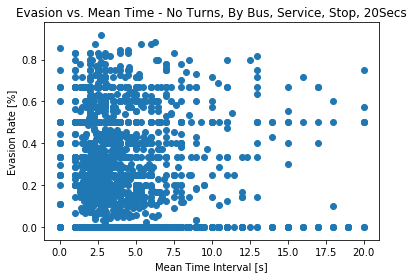

In [16]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 20Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/9_20Secs_EvasionVsMeanTimeByBusByServiceByStop.pdf')

### Analyzing - 20Secs

In [22]:
not_null_mean_count_summary_no_turns = not_null_mean_count_summary_no_turns.reset_index(drop=True)

* Obs. with diferencia_tiempo_secs_mean>=18

In [23]:
not_null_mean_count_summary_no_turns[not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']>=18]

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE
228,BJFD69,508,4,L-32-19-10-OP,2017-03-15 10:32:48,2017-03-15 10:33:06,2,18.0,2017-03-15 10:32:41,2017-03-15 10:34:01.500000,1.0,2.0,0.0,NaT,False,False,0.000000
263,BJFR91,363,2,L-34-9-20-NS,2017-03-15 10:09:37,2017-03-15 10:09:57,2,20.0,2017-03-15 10:09:01.500000,2017-03-15 10:10:27,1.0,2.0,0.0,NaT,False,False,0.000000
317,CJRT79,454,6,T-31-134-SN-25,2017-03-15 17:02:51,2017-03-15 17:03:10,2,19.0,2017-03-15 17:02:32,2017-03-15 17:04:12.500000,1.0,3.0,0.0,NaT,False,False,0.000000
1078,CJRW86,360,4,L-33-59-55-PO,2017-04-18 09:22:13,2017-04-18 09:22:33,2,20.0,2017-04-18 09:21:56.500000,2017-04-18 09:25:08,1.0,1.0,0.0,NaT,False,False,0.000000
1113,CRXT55,B51,33,L-16-21-25-OP,2017-04-18 14:59:29,2017-04-18 14:59:49,2,20.0,2017-04-18 14:58:59.500000,2017-04-18 15:00:19.500000,1.0,2.0,1.0,NaT,False,False,0.500000
1179,CJRX69,339,25,L-21-41-5-PO,2017-06-14 07:00:54,2017-06-14 07:01:13,2,19.0,2017-06-14 06:59:47.500000,2017-06-14 07:01:42.500000,1.0,2.0,0.0,NaT,False,False,0.000000
1436,CJRS46,406,1,E-20-53-PO-105,2017-07-11 07:45:29,2017-07-11 07:45:47,2,18.0,2017-07-11 07:44:29,2017-07-11 07:47:28,1.0,4.0,2.0,NaT,False,False,0.500000
1498,ZN4334,120,10,T-28-234-SN-10,2017-07-11 14:38:03,2017-07-11 14:38:23,2,20.0,2017-07-11 14:36:59.500000,2017-07-11 14:39:46.500000,2.0,7.0,4.0,NaT,False,False,0.571429
1521,ZN5077,120,11,T-28-233-NS-25,2017-07-11 08:03:52,2017-07-11 08:04:10,2,18.0,2017-07-11 08:03:25,2017-07-11 08:05:27.500000,1.0,2.0,0.0,NaT,False,False,0.000000
1563,CJRV65,456,43,L-32-28-2-OP,2017-07-13 15:17:44,2017-07-13 15:18:03,2,19.0,2017-07-13 15:17:14,2017-07-13 15:20:29,1.0,2.0,0.0,NaT,False,False,0.000000


* Row number 1973 is specially weird. Checking...

In [24]:
not_null_mean_count_summary_no_turns.loc[1973,:]

sitio_subida                                CJRX76
servicio_subida                                457
idExpedicion                                    12
par_subida                            L-33-84-5-OP
t_subida_min                   2017-07-19 12:16:10
t_subida_max                   2017-07-19 13:15:09
t_subida_count                                   3
diferencia_tiempo_secs_mean                     18
start_cut                      2017-07-19 12:15:40
end_cut                        2017-07-19 12:47:49
EVASION_COUNT                                    8
TOTAL_INGRESAN                                  20
TOTAL_NO_VALIDAN                                 2
fecha_instalacion                              NaT
SI_TORNIQUETE                                False
SI_2017_TORNIQUETE                           False
EVASION_RATE                                   0.1
Name: 1973, dtype: object

In [27]:
date = '2017-07-19'
patente = 'CJRX-76'
servicio = '457'
paradero = 'L-33-84-5-OP'

In [26]:
etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
processed_sorted_df = etapas_builder.runProcessedProcess()    

Not found in turnstile database: 1637796


In [29]:
processed_sorted_df = processed_sorted_df.reset_index(drop=True)

In [30]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['par_subida']==paradero)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
1150630,1380146,2501161870,1,BUS,2017-07-19 07:16:08,T457 03I,L-33-84-5-OP,CJRX-76,NaT,False,True,True,NaT,NaN,False,False
1150698,688740,474307586,1,BUS,2017-07-19 09:32:16,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False
1150768,9244,24186706,1,BUS,2017-07-19 11:22:12,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False
1150793,1383987,2503728606,1,BUS,2017-07-19 12:16:10,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False
1150794,1487788,2687844446,1,BUS,2017-07-19 12:16:28,T457 00I,L-33-84-5-OP,CJRX-76,NaT,True,True,True,00:00:18,18.0,False,False
1150821,1006350,1369948350,2,BUS,2017-07-19 13:15:09,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,True,NaT,NaN,False,False
1150856,73289,35127314,1,BUS,2017-07-19 14:15:24,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False
1150903,1631751,2802915950,3,BUS,2017-07-19 16:10:01,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False
1150904,1005065,1363693412,1,BUS,2017-07-19 16:10:03,T457 00I,L-33-84-5-OP,CJRX-76,NaT,True,True,True,00:00:02,2.0,False,False
1151026,2106611,3656517163,2,BUS,2017-07-19 19:29:59,T457 00I,L-33-84-5-OP,CJRX-76,NaT,False,True,False,NaT,NaN,False,False


In [31]:
processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")

processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
 
print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
#Filtering special cases.
filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )

[evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
clean_sorted_df = clean_sorted_df.reset_index(drop=True)
print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df) #Appending (ad-hoc) id expedicion.

The number of rows in the original etapas database is: 2326044 rows.
The number of rows in the filtered (by special cases) etapas database is: 2267188 rows.


In [32]:
patente = 'CJRX76'
servicio = '457'
paradero = 'L-33-84-5-OP'

In [34]:
clean_sorted_df[(clean_sorted_df['sitio_subida']==patente)&(clean_sorted_df['par_subida']==paradero)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete,idExpedicion
5502,1380146,2501161870,1,BUS,2017-07-19 07:16:08,457,L-33-84-5-OP,CJRX76,NaT,False,True,True,NaT,NaN,False,False,7
5567,688740,474307586,1,BUS,2017-07-19 09:32:16,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,10
5629,9244,24186706,1,BUS,2017-07-19 11:22:12,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,11
5649,1383987,2503728606,1,BUS,2017-07-19 12:16:10,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,12
5650,1487788,2687844446,1,BUS,2017-07-19 12:16:28,457,L-33-84-5-OP,CJRX76,NaT,True,True,True,00:00:18,18.0,False,False,12
5672,1006350,1369948350,2,BUS,2017-07-19 13:15:09,457,L-33-84-5-OP,CJRX76,NaT,False,True,True,NaT,NaN,False,False,12
5704,73289,35127314,1,BUS,2017-07-19 14:15:24,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,13
5743,1631751,2802915950,3,BUS,2017-07-19 16:10:01,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,15
5744,1005065,1363693412,1,BUS,2017-07-19 16:10:03,457,L-33-84-5-OP,CJRX76,NaT,True,True,True,00:00:02,2.0,False,False,15
5851,2106611,3656517163,2,BUS,2017-07-19 19:29:59,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,18


In [36]:
clean_sorted_df.loc[5645:5672]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete,idExpedicion
5645,858113,918672379,3,BUS,2017-07-19 11:48:48,457,L-32-28-2-OP,CJRX76,NaT,True,True,True,00:00:17,17.0,False,False,11
5646,1953102,3541942539,1,BUS,2017-07-19 11:48:55,457,L-32-28-2-OP,CJRX76,NaT,True,True,True,00:00:07,7.0,False,False,11
5647,2118986,3727357672,1,BUS,2017-07-19 12:00:54,457,L-32-25-5-SN,CJRX76,NaT,False,True,True,NaT,NaN,False,False,11
5648,1819090,3257056216,1,BUS,2017-07-19 12:00:57,457,L-32-25-5-SN,CJRX76,NaT,True,True,True,00:00:03,3.0,False,False,11
5649,1383987,2503728606,1,BUS,2017-07-19 12:16:10,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,12
5650,1487788,2687844446,1,BUS,2017-07-19 12:16:28,457,L-33-84-5-OP,CJRX76,NaT,True,True,True,00:00:18,18.0,False,False,12
5651,644287,433380418,1,BUS,2017-07-19 12:20:29,457,L-32-31-25-SN,CJRX76,NaT,False,True,True,NaT,NaN,False,False,12
5652,1750887,3168516478,1,BUS,2017-07-19 12:23:52,457,L-32-7-50-SN,CJRX76,NaT,False,True,True,NaT,NaN,False,False,12
5653,5023,23461394,1,BUS,2017-07-19 12:28:19,457,L-32-23-55-OP,CJRX76,NaT,False,True,True,NaT,NaN,False,False,12
5654,559493,423689090,1,BUS,2017-07-19 12:28:20,457,L-32-23-55-OP,CJRX76,NaT,True,True,True,00:00:01,1.0,False,False,12


In [33]:
clean_sorted_df_1[(clean_sorted_df_1['sitio_subida']==patente)&(clean_sorted_df_1['par_subida']==paradero)]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete,idExpedicion
5502,1380146,2501161870,1,BUS,2017-07-19 07:16:08,457,L-33-84-5-OP,CJRX76,NaT,False,True,True,NaT,NaN,False,False,7
5567,688740,474307586,1,BUS,2017-07-19 09:32:16,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,10
5629,9244,24186706,1,BUS,2017-07-19 11:22:12,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,11
5649,1383987,2503728606,1,BUS,2017-07-19 12:16:10,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,12
5650,1487788,2687844446,1,BUS,2017-07-19 12:16:28,457,L-33-84-5-OP,CJRX76,NaT,True,True,True,00:00:18,18.0,False,False,12
5672,1006350,1369948350,2,BUS,2017-07-19 13:15:09,457,L-33-84-5-OP,CJRX76,NaT,False,True,True,NaT,NaN,False,False,12
5704,73289,35127314,1,BUS,2017-07-19 14:15:24,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,13
5743,1631751,2802915950,3,BUS,2017-07-19 16:10:01,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,15
5744,1005065,1363693412,1,BUS,2017-07-19 16:10:03,457,L-33-84-5-OP,CJRX76,NaT,True,True,True,00:00:02,2.0,False,False,15
5851,2106611,3656517163,2,BUS,2017-07-19 19:29:59,457,L-33-84-5-OP,CJRX76,NaT,False,True,False,NaT,NaN,False,False,18


In [37]:
from Utils import PrintLinesUtils

In [38]:
PrintLinesUtils.readAndPrintLines('perfiles','10','2017-03-01')

ServicioSentido|Patente|Paradero|NombreParada|Hini|Hfin|Cumplimiento|Correlativo|idExpedicion|DistEnRuta|#Subidas|#SubidasLejanas|Subidastotal|SubidasExpandidas|#Bajadas|#BajadasLejanas|Bajadastotal|BajadasExpandidas|Carga|Capacidad|TiempoGPSInterpolado|TiempoPrimeraTrx|TiempoGPSMasCercano|Tiempo|nSubidasTmp|ParaderoUsuario|PeriodoTSExpedicion|PeriodoTSParada|TipoDia|ZP|DeltaTrxs 

T118 00I|ZB-6854|T-13-369-PO-5|René Olivares esq. / Los Olivares|2017-03-01 01:32:45|2017-03-01 01:42:14|NC|1|0|120|0|0|0|0|0|0|0|0|0|91|-|-|01:32:15|2017-03-01 01:32:15|0|PI528|02 - NOCTURNO|02 - NOCTURNO|LABORAL|0|0

T118 00I|ZB-6854|L-13-69-5-PO|René Olivares esq. / Avenida 4 Poniente|2017-03-01 01:32:45|2017-03-01 01:42:14|NC|2|0|392|0|0|0|0|0|0|0|0|0|91|01:32:23|-|01:32:15|2017-03-01 01:32:23|0|PI529|02 - NOCTURNO|02 - NOCTURNO|LABORAL|0|0

T118 00I|ZB-6854|L-13-3-42-SN|Avenida 4 Poniente esq. / Pdte. J.M Balmaceda|2017-03-01 01:32:45|2017-03-01 01:42:14|NC|3|0|595|0|0|0|0|0|0|0|0|0|91|01:35:20|-|01:33:

* Re-doing for timeDelta = 30 seconds

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [5]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing complete evasion-ddbb

In [6]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [7]:
print('Number of rows in complete evasion database is: ' + str(len(processed_evasion.index)))
print('Number of rows in evasion in paradero database is: ' + str(len(evasion_paradero.index)))
print('Number of rows in evasion in paradero by first door database is: ' + str(len(evasion_paradero_first.index)))

Number of rows in complete evasion database is: 94271
Number of rows in evasion in paradero database is: 92604
Number of rows in evasion in paradero by first door database is: 33120


* Filtering dates not in common dates. DataFrame "common_dates_evasion" will be the final evasion DataFrame

In [8]:
common_dates = TransantiagoConstants.common_dates
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]
common_dates_evasion = evasion_paradero_first[evasion_paradero_first['FECHA'].isin(common_dates_timestamp)]

print('Number of rows in complete evasion database filtered by common_dates is: ' + str(len(common_dates_evasion.index))) #Remember to store the number.

Number of rows in complete evasion database filtered by common_dates is: 14632


* Building Etapas DataBase via <strong>RunSilentlyDailyEtapasBuilder</strong> and matching users via <strong>MatchingUsers</strong>

In [9]:
#common_dates = ['2017-04-11']

In [10]:
from RunSilentlyDailyEtapasBuilder import RunSilentlyDailyEtapasBuilderClass

In [11]:
import MatchingUsers

In [12]:
summary_evasion_vs_mean = pd.DataFrame()

for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
    processed_sorted_df = etapas_builder.runProcessedProcess()    
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
    #Filtering special cases.
#    filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
    filtered_processed_sorted_df = processed_sorted_df
    print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
    clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

    clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df,'30 seconds') #Appending (ad-hoc) id expedicion.
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df_1) #Grouping by 'sitio_subida','servicio_subida','idExpedicion','par_subida'
    grouped_clean_sorted_df_2 = MatchingUsers.appendingStartEndCuts(grouped_clean_sorted_df_1) #Computing start and end cuts.
    grouped_clean_sorted_df_3 = MatchingUsers.slicingEvasionDatabase(grouped_clean_sorted_df_2,evasion_by_date) #This is the final ddbb with full info.
    grouped_clean_sorted_df_4 = MatchingUsers.reMergeTurnstileData(grouped_clean_sorted_df_3)
    summary_evasion_vs_mean = pd.concat([summary_evasion_vs_mean,grouped_clean_sorted_df_4]) 

Not found in turnstile database: 1795630
The number of rows in the original etapas database is: 2535246 rows.
The number of rows in the filtered (by special cases) etapas database is: 2473922 rows.
The number of rows in the clean_sorted_df is: 2492 rows.
Not found in turnstile database: 1832615
The number of rows in the original etapas database is: 2591725 rows.
The number of rows in the filtered (by special cases) etapas database is: 2528203 rows.
The number of rows in the clean_sorted_df is: 2842 rows.
Not found in turnstile database: 1842842
The number of rows in the original etapas database is: 2612985 rows.
The number of rows in the filtered (by special cases) etapas database is: 2549011 rows.
The number of rows in the clean_sorted_df is: 9216 rows.
Not found in turnstile database: 1821215
The number of rows in the original etapas database is: 2589603 rows.
The number of rows in the filtered (by special cases) etapas database is: 2527375 rows.
The number of rows in the clean_sorte

In [13]:
print('The number of rows in the summary_evasion_vs_mean: '  + str(len(summary_evasion_vs_mean.index)) + ' rows.' )

The number of rows in the summary_evasion_vs_mean: 54974 rows.


In [14]:
summary_evasion_vs_mean.loc[:,'EVASION_RATE'] = summary_evasion_vs_mean.loc[:,'TOTAL_NO_VALIDAN']/summary_evasion_vs_mean.loc[:,'TOTAL_INGRESAN']

not_null_mean_summary = summary_evasion_vs_mean[summary_evasion_vs_mean['diferencia_tiempo_secs_mean'].notnull()]
not_null_mean_count_summary = not_null_mean_summary[not_null_mean_summary['EVASION_COUNT']>0]
not_null_mean_count_summary_no_turns = not_null_mean_count_summary[(not_null_mean_count_summary['SI_TORNIQUETE']==False)|((not_null_mean_count_summary['SI_TORNIQUETE']==True) & (not_null_mean_count_summary['t_subida_max']<=not_null_mean_count_summary['fecha_instalacion']))]

In [15]:
print('The number of rows in the not_null_mean_summary dataframe is: ' + str(len(not_null_mean_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary dataframe is: ' + str(len(not_null_mean_count_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary_no_turns dataframe is: ' + str(len(not_null_mean_count_summary_no_turns.index)) + ' rows.')

The number of rows in the not_null_mean_summary dataframe is: 27534 rows.
The number of rows in the not_null_mean_count_summary dataframe is: 2703 rows.
The number of rows in the not_null_mean_count_summary_no_turns dataframe is: 2053 rows.


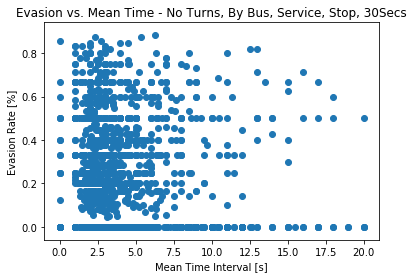

In [17]:
fig_2, ax_2 = plt.subplots()

ax_2.scatter(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns['EVASION_RATE'])
ax_2.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_2.set_xlabel('Mean Time Interval [s]')
ax_2.set_ylabel('Evasion Rate [%]')

plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/9_30Secs_EvasionVsMeanTimeByBusByServiceByStop.pdf')

### Analyzing - 30Secs (but via different methodology)

In [18]:
not_null_mean_count_summary_no_turns = not_null_mean_count_summary_no_turns.reset_index(drop=True)

* Obs. with diferencia_tiempo_secs_mean>=18

In [19]:
not_null_mean_count_summary_no_turns[not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']>=18]

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE
139,BJFD69,508,49,L-32-19-10-OP,2017-03-15 10:32:48,2017-03-15 10:33:06,2,18.0,2017-03-15 10:32:41,2017-03-15 10:33:36,1.0,2.0,0.0,NaT,False,False,0.0
163,BJFR91,363,21,L-34-9-20-NS,2017-03-15 10:09:37,2017-03-15 10:09:57,2,20.0,2017-03-15 10:09:07,2017-03-15 10:10:27,1.0,2.0,0.0,NaT,False,False,0.0
202,CJRT79,454,96,T-31-134-SN-25,2017-03-15 17:02:51,2017-03-15 17:03:10,2,19.0,2017-03-15 17:02:21,2017-03-15 17:03:40,1.0,3.0,0.0,NaT,False,False,0.0
764,CJRW86,360,40,L-33-59-55-PO,2017-04-18 09:22:13,2017-04-18 09:22:33,2,20.0,2017-04-18 09:21:43,2017-04-18 09:23:03,1.0,1.0,0.0,NaT,False,False,0.0
788,CRXT55,B51,519,L-16-21-25-OP,2017-04-18 14:59:29,2017-04-18 14:59:49,2,20.0,2017-04-18 14:58:59,2017-04-18 15:00:19,1.0,2.0,1.0,NaT,False,False,0.5
1039,CJRS46,406,25,E-20-53-PO-105,2017-07-11 07:45:29,2017-07-11 07:45:47,2,18.0,2017-07-11 07:44:59,2017-07-11 07:46:17,1.0,4.0,2.0,NaT,False,False,0.5
1093,ZN5077,120,333,T-28-233-NS-25,2017-07-11 08:03:52,2017-07-11 08:04:10,2,18.0,2017-07-11 08:03:22,2017-07-11 08:04:40,1.0,2.0,0.0,NaT,False,False,0.0
1129,CJRV65,456,605,L-32-28-2-OP,2017-07-13 15:17:44,2017-07-13 15:18:03,2,19.0,2017-07-13 15:17:14,2017-07-13 15:18:33,1.0,2.0,0.0,NaT,False,False,0.0
1363,BJFW95,358,421,L-33-50-40-SN,2017-07-19 16:59:54,2017-07-19 17:00:12,2,18.0,2017-07-19 16:59:45.500000,2017-07-19 17:00:42,1.0,5.0,3.0,NaT,False,False,0.6
1730,CJRG41,F18,584,L-34-40-15-PO,2017-08-17 18:36:58,2017-08-17 18:37:18,2,20.0,2017-08-17 18:36:28,2017-08-17 18:37:48,1.0,1.0,0.0,NaT,False,False,0.0


In [20]:
not_null_mean_count_summary_no_turns[not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']==0]

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE
34,FLXR82,F05,345,L-34-34-20-OP,2017-03-09 18:00:23,2017-03-09 18:00:23,2,0.0,2017-03-09 17:59:53,2017-03-09 18:00:53,1.0,4.0,1.0,2017-04-21,True,True,0.250000
140,BJFD69,508,50,L-31-6-10-OP,2017-03-15 10:34:57,2017-03-15 10:34:57,2,0.0,2017-03-15 10:34:27,2017-03-15 10:35:27,1.0,3.0,1.0,NaT,False,False,0.333333
144,BJFD69,508,58,T-18-130-SN-1,2017-03-15 10:57:58,2017-03-15 10:57:58,2,0.0,2017-03-15 10:57:28,2017-03-15 10:58:28,1.0,3.0,0.0,NaT,False,False,0.000000
146,BJFD69,508,66,T-20-73-OP-55,2017-03-15 11:39:03,2017-03-15 11:39:03,2,0.0,2017-03-15 11:38:33,2017-03-15 11:39:33,1.0,2.0,0.0,NaT,False,False,0.000000
186,BJFT26,363,272,L-34-9-10-SN,2017-03-15 10:27:48,2017-03-15 10:27:48,2,0.0,2017-03-15 10:27:18,2017-03-15 10:28:18,1.0,1.0,0.0,NaT,False,False,0.000000
259,BBKB13,F11,114,L-34-40-260-OP,2017-03-16 07:19:55,2017-03-16 07:19:55,2,0.0,2017-03-16 07:19:25,2017-03-16 07:20:25,1.0,6.0,0.0,NaT,False,False,0.000000
335,BKXV93,F11,18,L-34-40-310-SN,2017-03-16 09:30:34,2017-03-16 09:30:34,2,0.0,2017-03-16 09:30:04,2017-03-16 09:31:04,1.0,1.0,0.0,NaT,False,False,0.000000
405,BJFF41,507,234,T-10-64-PO-3,2017-04-11 09:38:01,2017-04-11 09:38:01,2,0.0,2017-04-11 09:37:31,2017-04-11 09:38:31,1.0,2.0,0.0,NaT,False,False,0.000000
480,CJRV11,456,115,L-18-11-5-NS,2017-04-11 07:47:19,2017-04-11 07:47:19,2,0.0,2017-04-11 07:46:49,2017-04-11 07:47:49,1.0,5.0,3.0,NaT,False,False,0.600000
486,CJRX88,456,354,L-31-7-5-SN,2017-04-11 08:48:25,2017-04-11 08:48:25,2,0.0,2017-04-11 08:47:55,2017-04-11 08:48:55,1.0,2.0,0.0,NaT,False,False,0.000000
